In [169]:
import os
import json
import requests
import datetime
from tqdm.notebook import tqdm
import math
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, make_scorer, r2_score, mean_absolute_error, median_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, minmax_scale
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import lightgbm as lgb


In [170]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [171]:
DATA_DIR = './datasets/'

### Collecting Data

In [172]:
# берем данные из файлов, мерджим в один датафрейм, добавляем новые столбцы 'restaurant_id', 'restaurant_cat', 'package'
data_res = []
 
for count, category in enumerate(['Low', 'Mid', 'Hi']):
    for filename in os.listdir(DATA_DIR + category):
        if 'data' in filename:
            arr_name = filename.split('_')
            df_temp = pd.read_csv(f'{DATA_DIR}{category}/{filename}', sep=';', parse_dates=['date'])
            df_temp['restaurant_id'] = arr_name[0]
#             перфоманс ресторана это ordinal feature, от 0 до 2
            df_temp['restaurant_cat'] = count
            
            package_df = pd.read_csv(f'{DATA_DIR}{category}/{arr_name[0]}_package.csv', sep=';')
            df_new = pd.merge(df_temp, package_df, how='left', on = 'item_id')
            df_new.rename(columns={"k": "package"}, inplace=True)
            
            data_res.append(df_new)

df = pd.concat(data_res)

# заменим для удобства длинный GUID ингредиентов на более короткие обозначения
map_ingridients = { i : str(count) for count, i in enumerate(df.item_id.unique()) }

df['item_id'] = df['item_id'].map(map_ingridients)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126634 entries, 0 to 15059
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            126634 non-null  datetime64[ns]
 1   item_id         126634 non-null  object        
 2   stock           126634 non-null  float64       
 3   consumption_12  126634 non-null  float64       
 4   consumption     126634 non-null  float64       
 5   write_off       126634 non-null  float64       
 6   sale_stop       126634 non-null  int64         
 7   restaurant_id   126634 non-null  object        
 8   restaurant_cat  126634 non-null  int64         
 9   package         126634 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 10.6+ MB


date item_id  stock  consumption_12  consumption  write_off  \
0 2020-01-01       0   29.0             0.0          0.0        0.0   
1 2020-01-01       1    3.0             0.0          0.0        0.0   
2 2020-01-01       2  470.0             0.0          0.0        0.0   
3 2020-01-01       3  300.0             0.0          0.0        0.0   
4 2020-02-01       4  340.0             0.0          0.0        0.0   

   sale_stop restaurant_id  restaurant_cat  package  
0          0     000000496               0       12  
1          0     000000496               0        1  
2          0     000000496               0        1  
3          0     000000496               0      400  
4          0     000000496               0      170

# Data Exploration

In [152]:
# в выборке нет отсутствующих значений
print(df.isna().sum())

date              0
item_id           0
stock             0
consumption_12    0
consumption       0
write_off         0
sale_stop         0
restaurant_id     0
restaurant_cat    0
package           0
dtype: int64


In [122]:
# самая ранняя и самая поздняя даты в наборе данных
print('Min date: ', df.index.min(), 'Max date: ', df.index.max(), df.index.max() - df.index.min())

Min date:  0 Max date:  15120 15120


In [123]:
# датасет содержит разное количество записей на календарный день
df.index.value_counts().head(7)

2047     9
11603    9
9682     9
3479     9
1430     9
7573     9
5524     9
dtype: int64

In [153]:
def set_date_index(df):
    if not 'date' in df.columns:
        return
    # индекс по дате
    df.sort_values(by='date', inplace=True, ascending=True)
    df.set_index('date', drop=True, inplace=True)
    # монотонно возрастающий ряд
    if not df.index.is_monotonic:
        print('Index is not monotonic!')

In [185]:
set_date_index(df)

In [155]:
rs,cs = df.shape

df.drop_duplicates(inplace=True)

print('Does the dataset have any duplicates? ', (rs,cs) == df.shape)

Does the dataset have any duplicates?  False


### Correlation Matrice

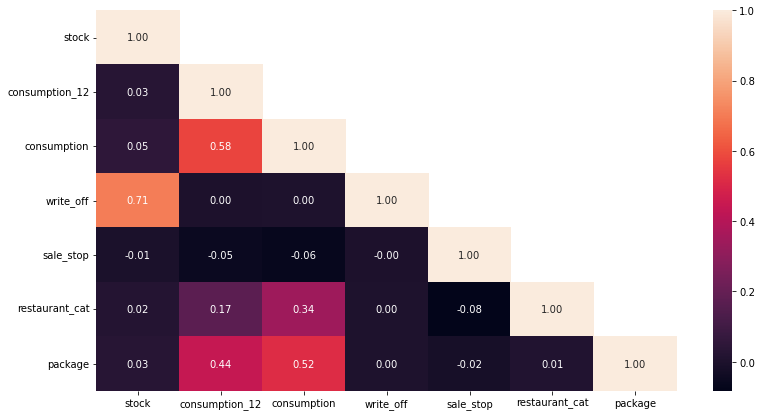

In [127]:
corr = df.corr()
plt.figure(figsize=(13,7))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)]=True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')

В матрице корреляций есть заметная положительная корреляция между признаками stock и write_off, что вполне объяснимо - чем больше остатки на начало дня, тем больше среди них продуктов с истекающим сроком годности, которые подлежат списанию в этот день. Ниже мы сделаем один признак из этих двух.

Теоретически, нельзя списать больше продукта, чем его есть на стоке в этот день. Однако, в наборе данных нашлось две такие записи за один день в одном ресторане, когда ингредиентов 1 и 3 было списано больше, чем их было в наличии.

In [128]:
df[df.write_off > df.stock]

item_id  stock  consumption_12  consumption  write_off  sale_stop  \
date                                                                           
2020-03-27       3  320.0             0.0       58.000    480.000          0   
2020-03-27       1    3.0             0.0        0.264      5.694          0   

           restaurant_id  restaurant_cat  package  
date                                               
2020-03-27     000000323               1      400  
2020-03-27     000000323               1        1

### Anomalous write-offs

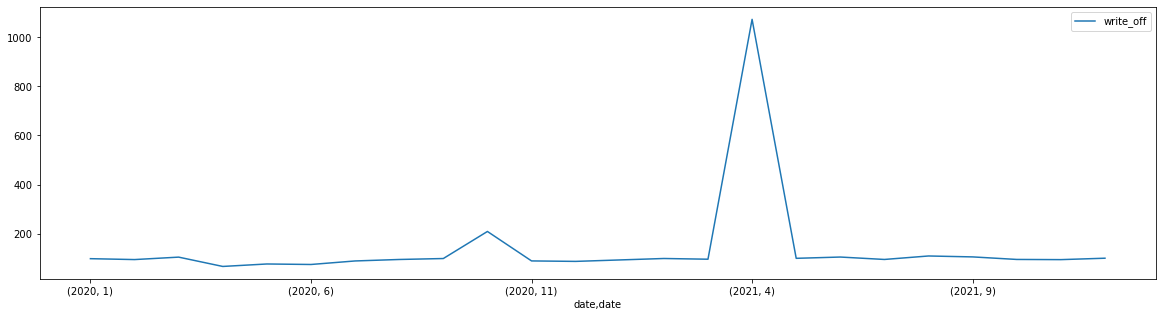

In [129]:
# аномальное высокое списание ингредиентов в апреле 2021
df.groupby([df.index.year, df.index.month]).agg({'write_off':'mean'}).plot(figsize=(20,5))

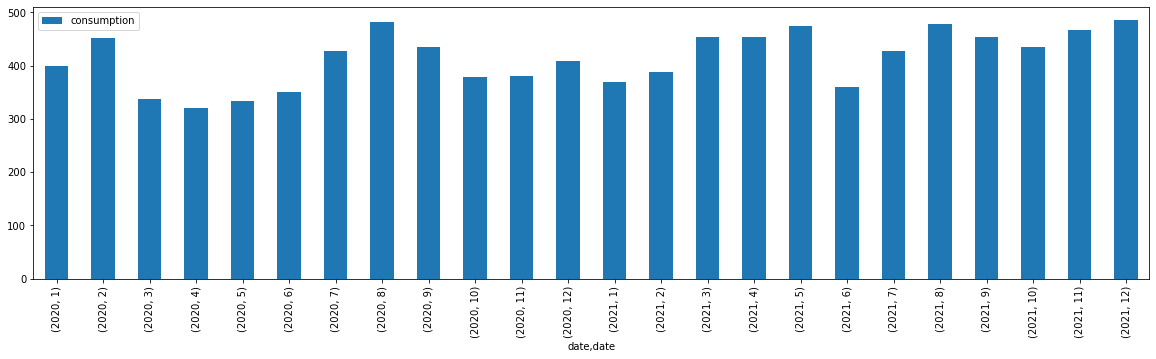

In [130]:
# при этом средний расход не выглядит необычно
df.groupby([df.index.year, df.index.month]).agg({'consumption':'mean'}).plot(kind='bar', figsize=(20,5))

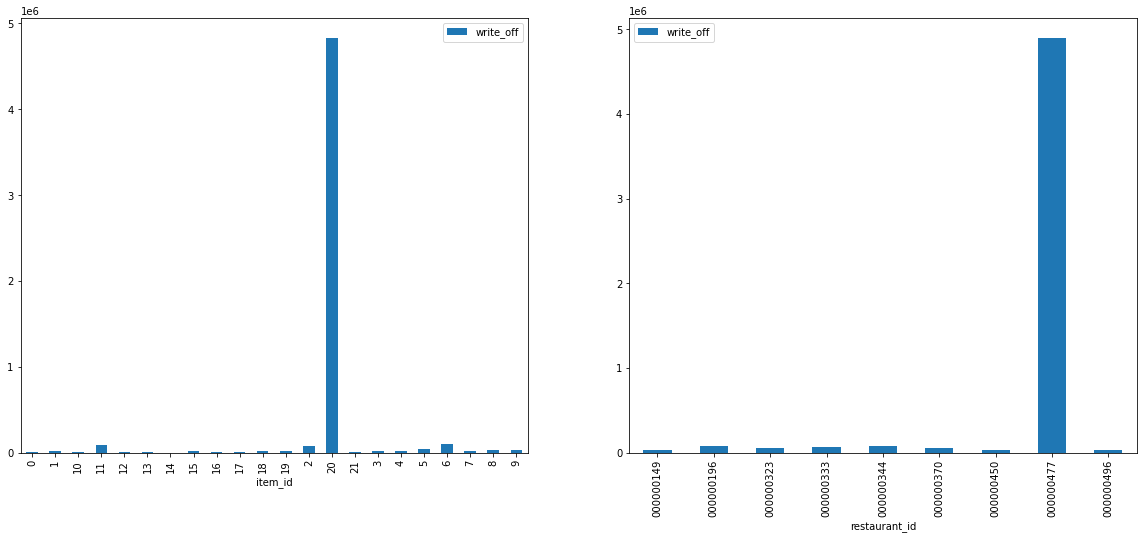

In [131]:
# почти все аномальное списание приходится на ингредиент 20 и один ресторан, за месяц было списано 4.8 млн единиц продукта
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

df.loc[(df.index.year == 2021) & (df.index.month == 4)].groupby('item_id').agg({'write_off':'sum'}).plot.bar(ax=axes[0])
df.loc[(df.index.year == 2021) & (df.index.month == 4)].groupby('restaurant_id').agg({'write_off':'sum'}).plot.bar(ax=axes[1])

**Inference**: в предоставленных данных либо есть ошибка, либо что-то произошло в ресторане 477, слишком большой сток и списание.

Поскольку корреляция между признаками stock и write_off значительная, чтобы не было мультиколлинеарности признаков, объединим эти два признака в один - отношение списанного ингредиента к дневному стоку.

In [173]:
# вместо двух коррелирующих признаков создадим один
df['write_off_p'] = df['write_off'] / df['stock'] * 100
df.drop(columns=['write_off', 'stock'], inplace=True) 

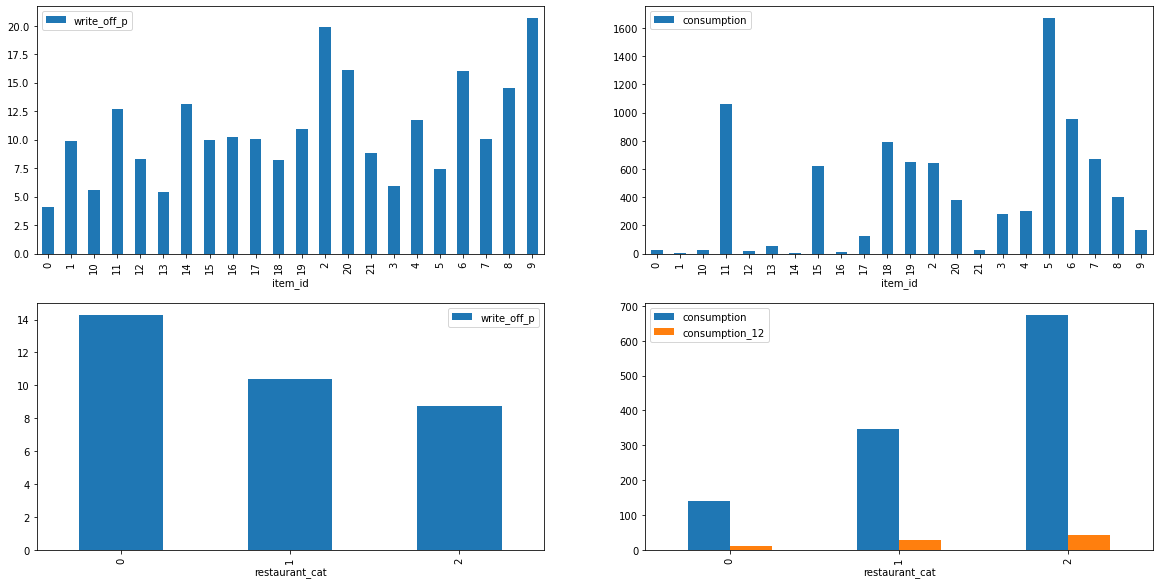

In [133]:
# среднее списание по ингредиентам, по категориям ресторанов, средний расход по ресторанам
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

df.groupby(['item_id']).agg({'write_off_p':'mean'}).plot.bar(ax=axes[0,0])
df.groupby(['item_id']).agg({'consumption':'mean'}).plot.bar(ax=axes[0,1])

df.groupby(['restaurant_cat']).agg({'write_off_p':'mean'}).plot.bar(ax=axes[1,0])
df.groupby('restaurant_cat').agg({'consumption':'mean','consumption_12':'mean'}).plot.bar(ax=axes[1,1])


**Inference**: Не все ингредиенты списываются одинаково, например, у ингредиентов 2 и 9 в среднем списывается почти 20%. Самая высокая доля списаний у ресторанов с наименьшим перфомансом, рестораны с высокими продажами, напротив, списывают меньше продуктов. 

### Ingredients


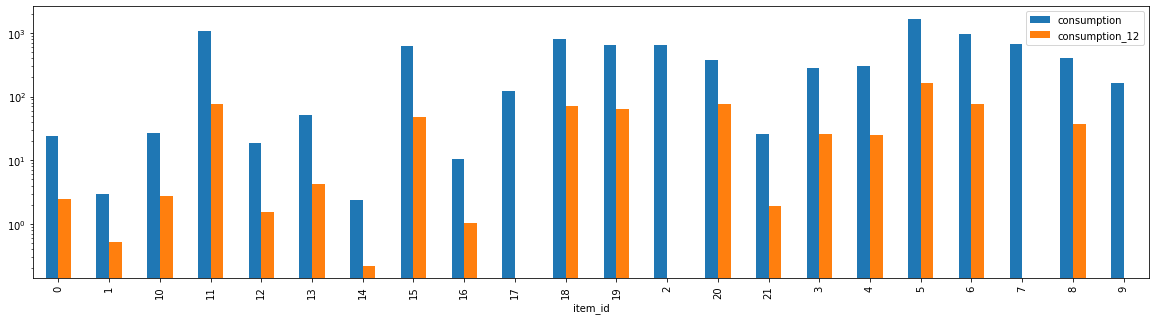

In [134]:
# средний расход по ингредиентам
df.groupby('item_id').agg({'consumption':'mean','consumption_12':'mean'}).plot(kind='bar', figsize=(20, 5))
plt.yscale('log')

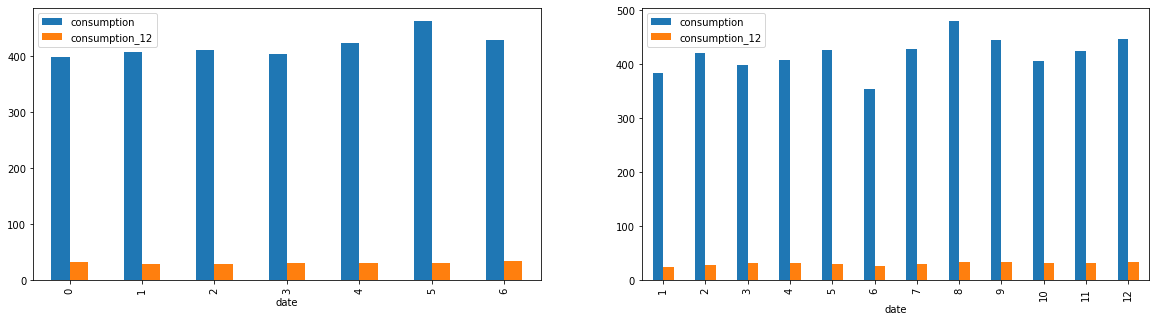

In [135]:
# расход по дням недели (в субботу незначительно больше), расход по месяцам, июнь - меньше потребления
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

df.groupby(df.index.weekday).agg({'consumption':'mean','consumption_12':'mean'}).plot.bar(ax=axes[0])
df.groupby(df.index.month).agg({'consumption':'mean','consumption_12':'mean'}).plot.bar(ax=axes[1])

In [174]:
# удалим consumption_12 (т.к. его следует рассматривать как часть таргета)
df.drop(columns=['consumption_12'], axis=1, inplace=True)

**Inference**: у некоторых ингредиентов расхода после полудня нет вообще, день недели с самым высоким средним потреблением - суббота, в июне есть небольшая просадка

### Trend, seasonality

Тест Дики-Фуллера показывает, что ряд стационарный.

In [137]:
# проверим тренд, тест Дики-Фуллера на стационарность 
# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary
result = adfuller(df.groupby(df.index).agg({'consumption': 'mean'}))

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.074216
p-value: 0.000016
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


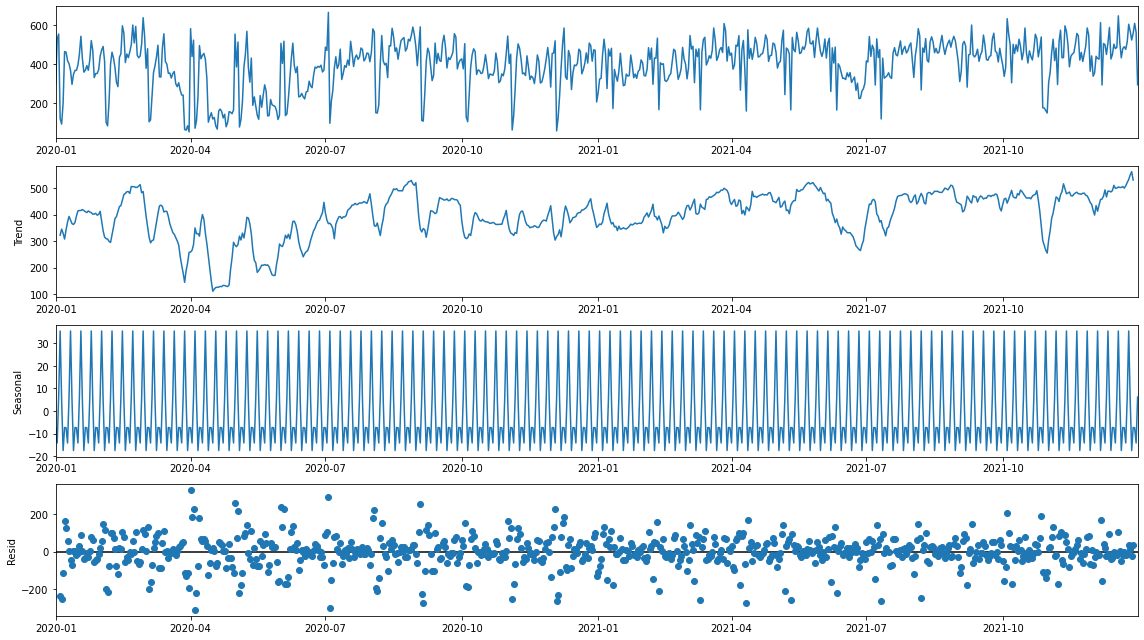

In [138]:
decomposed_data = seasonal_decompose(df.groupby(df.index).agg({'consumption': 'mean'}))
fig = decomposed_data.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [139]:
# посмотрим сезонность ближе на разных произвольных периодах
def plot_week_seasonal(df):
    fig, ax = plt.subplots()
    x = list(range(21))
    labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
    labels *= 3

    for i, df_part in enumerate([
        df['2021-03-15':'2021-04-04'],
        df['2021-06-14':'2021-07-04'],
        df['2021-09-13':'2021-10-03'],
        df['2021-12-06':'2021-12-26']
    ]):
        decomposed_test = seasonal_decompose(df_part.groupby(df_part.index).agg({'consumption': 'mean'}))
        Y = minmax_scale(decomposed_test.seasonal.values)
        ax.plot(x, Y)

    ax.set_xticks(x)
    ax.legend(['March', 'June', 'September', 'December'])
    ax.set_xticklabels(labels, rotation ='45')
    fig.set_size_inches(20, 5);

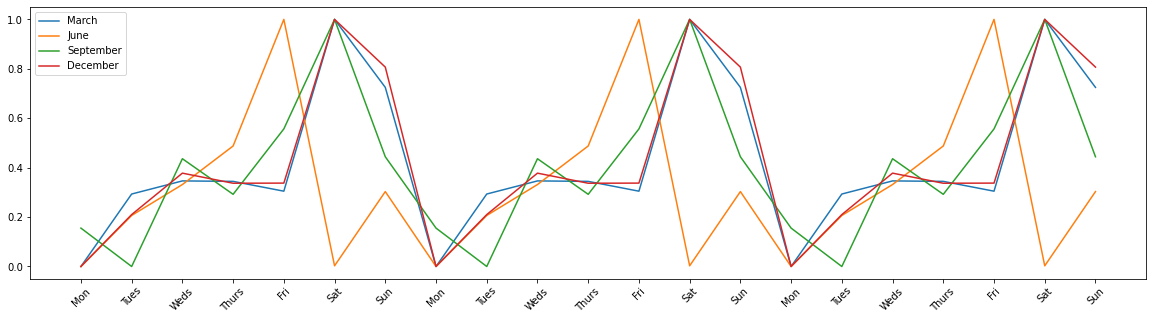

In [140]:
plot_week_seasonal(df)

Не похоже, что есть четкая сезонность по дням недели (здесь выбраны недели конца каждого квартала, другие периоды могут быть еще более разнородными), но день недели все таки добавим в датасет как признак.

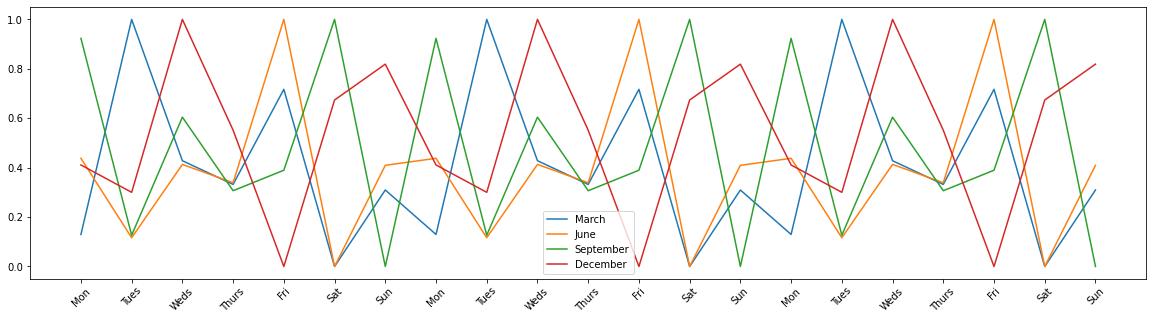

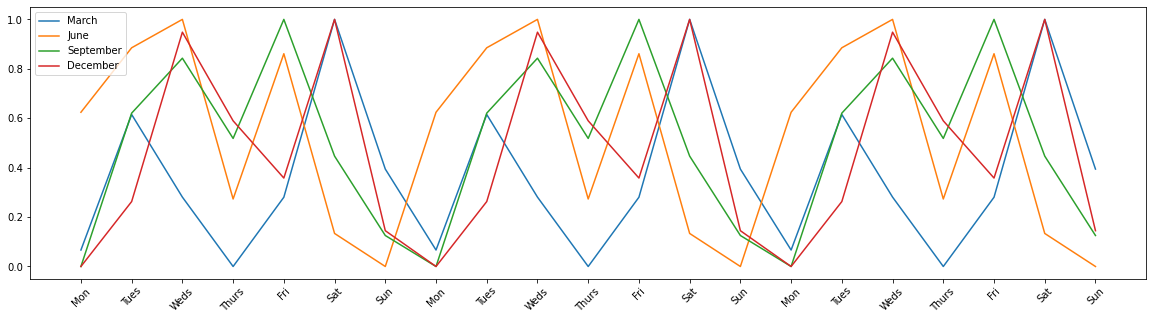

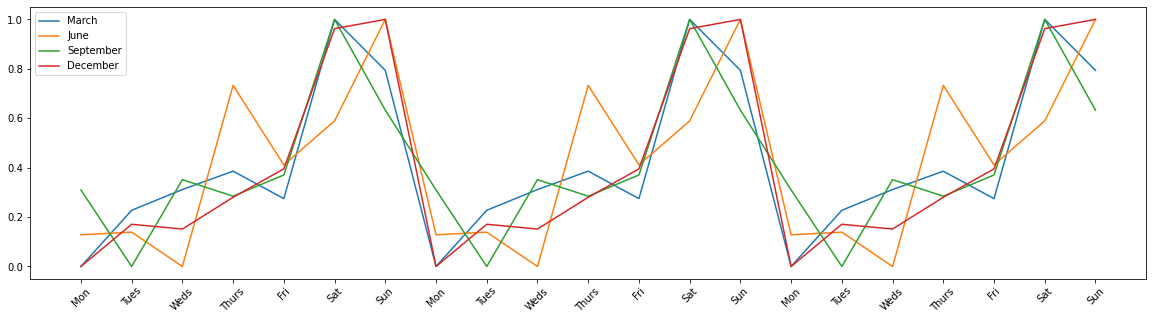

In [141]:
for i in range(3):
    plot_week_seasonal(df[df.restaurant_cat==i])

**Inference**: Чем выше категория ресторана, тем более выражена недельная сезонность.

### Поиск оптимального периода для прогнозирования

In [195]:
# добавим lagged дни, внешние признаки
def add_lag(df, max_lag, cols_to_lag):
    df_copy = df.copy(deep=True)
    
    df_copy.sort_values(by='date', inplace=True, ascending=True)
    set_date_index(df_copy)
    
    for lag in range(1, max_lag + 1):
        for col in cols_to_lag:
            df_copy[f'lag({col},{lag})'] = df_copy.groupby(['restaurant_id', 'item_id'])[col].shift(lag)
    
    return df_copy

In [176]:
def get_preprocessor(X):
    categorical_features = [col for col in X.columns if X[col].dtype=="O"]
    numeric_features = [col for col in X.columns if X[col].dtype!="O"]

    scaler = StandardScaler()
    encoder = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numeric_features),
            ('cat', encoder, categorical_features)])
    
    return preprocessor

In [177]:
def plot_models_evaluation(history_lag_linreg, history_lag_lgbm):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

    axes[0,0].plot(list(history_lag_lgbm.keys()), [v['r2'] for v in history_lag_lgbm.values()], label='r2')
    axes[0,0].legend()
    axes[0,0].set_title('r2 score for different lags (LGBM)')

    axes[0,1].plot(list(history_lag_lgbm.keys()), [v['rmse'] for v in history_lag_lgbm.values()], label='rmse')
    axes[0,1].legend()
    axes[0,1].set_title('RMSE for different lags (LGBM)')

    axes[1,0].plot(list(history_lag_linreg.keys()), [v['r2'] for v in history_lag_linreg.values()], label='r2')
    axes[1,0].legend()
    axes[1,0].set_title('r2 score for different lags (LinReg)')

    axes[1,1].plot(list(history_lag_linreg.keys()), [v['rmse'] for v in history_lag_linreg.values()], label='rmse')
    axes[1,1].legend()
    axes[1,1].set_title('RMSE for different lags (LinReg)')

In [178]:
def get_scores(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred) ** 0.5,
        'wape': sum(abs(y_true - y_pred)) / y_true.sum() * 100,
        'mae': mean_absolute_error(y_true, y_pred),
        'med_mae': median_absolute_error(y_true, y_pred)
    }

In [202]:
def evaluate_lags(df, features_to_lag=[], max_lag=15, with_external=False):
    history_lag_lgbm = dict.fromkeys(range(1, max_lag))
    history_lag_linreg = dict.fromkeys(range(1, max_lag))
    
    for i in tqdm(range(1, max_lag)):
        df_eval = add_lag(df, i, features_to_lag)
        df_eval.dropna(inplace=True)
    
        X = df_eval.drop(['consumption'], axis=1)
        y = df_eval['consumption']
        
        preprocessor = get_preprocessor(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train_t = preprocessor.fit_transform(X_train)
        X_test_t = preprocessor.transform(X_test)

        lgbm = lgb.LGBMRegressor(learning_rate=0.01, max_depth=8, n_estimators=300, num_leaves=16)
        linreg = LinearRegression()
        
        lgbm.fit(X_train_t, y_train)
        linreg.fit(X_train_t, y_train)
        
        y_pred_lgbm = lgbm.predict(X_test_t)
        y_pred_linreg = linreg.predict(X_test_t)

        history_lag_lgbm[i] = get_scores(y_test, y_pred_lgbm)
        history_lag_linreg[i] = get_scores(y_test, y_pred_linreg)
    
    plot_models_evaluation(history_lag_linreg, history_lag_lgbm)

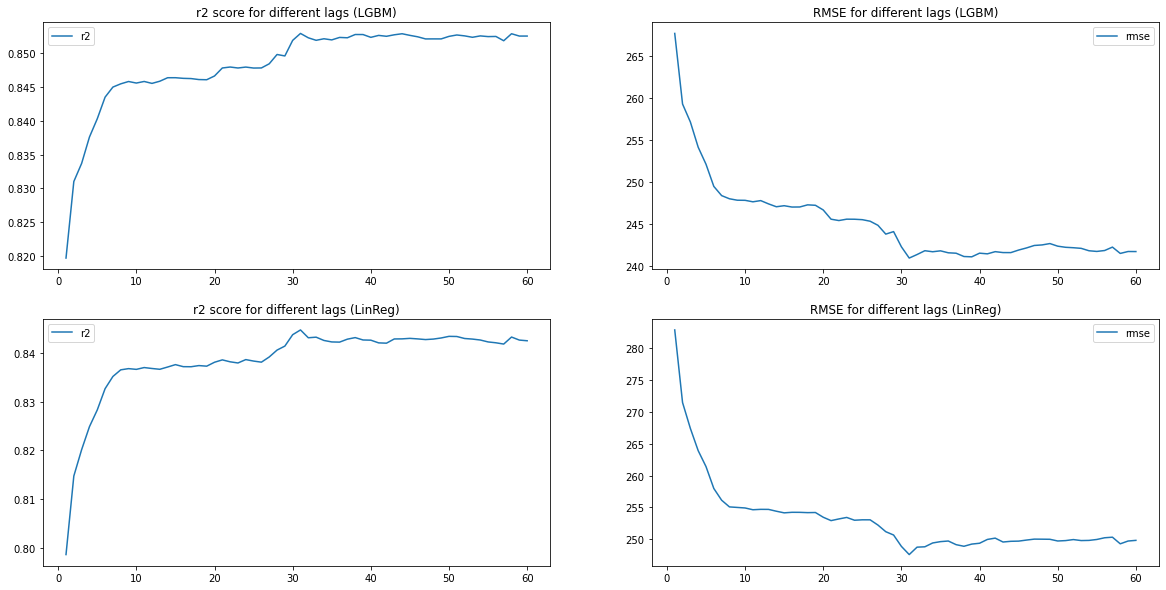

In [203]:
# проверим лаги до 2 месяцев
evaluate_lags(df, ['consumption', 'sale_stop', 'write_off_p'], 61)

**Inference**: при сравнении r2 и RSME метрик двух базовых моделей LinearRegression и LGBMRegressor, обученных на разных периодах от 1 дня до 2 месяцев, нужно отметить, что для обеих моделей обе метрики перестают улучшаться после 30 дней. 
Таким образом, для улучшения производительности и снижения размерности данных, кажется, что оптимальным будет остановиться на месячном периоде.

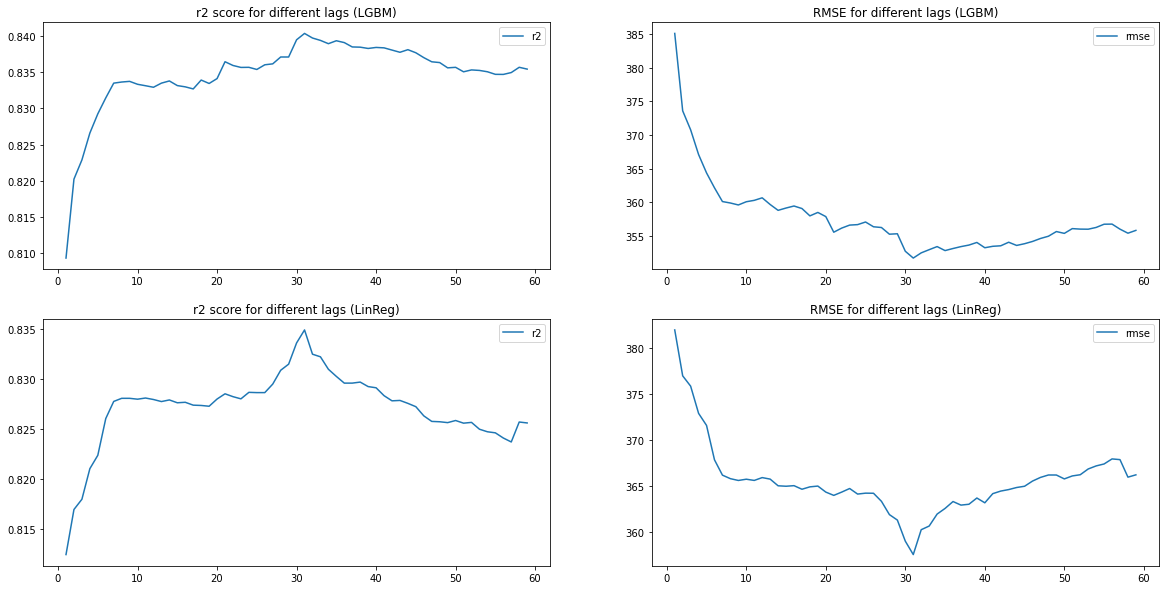

In [204]:
# проверим в рамках 'Hi' категории ресторана
evaluate_lags(df[df.restaurant_cat==2], ['consumption', 'sale_stop', 'write_off_p'], 60)

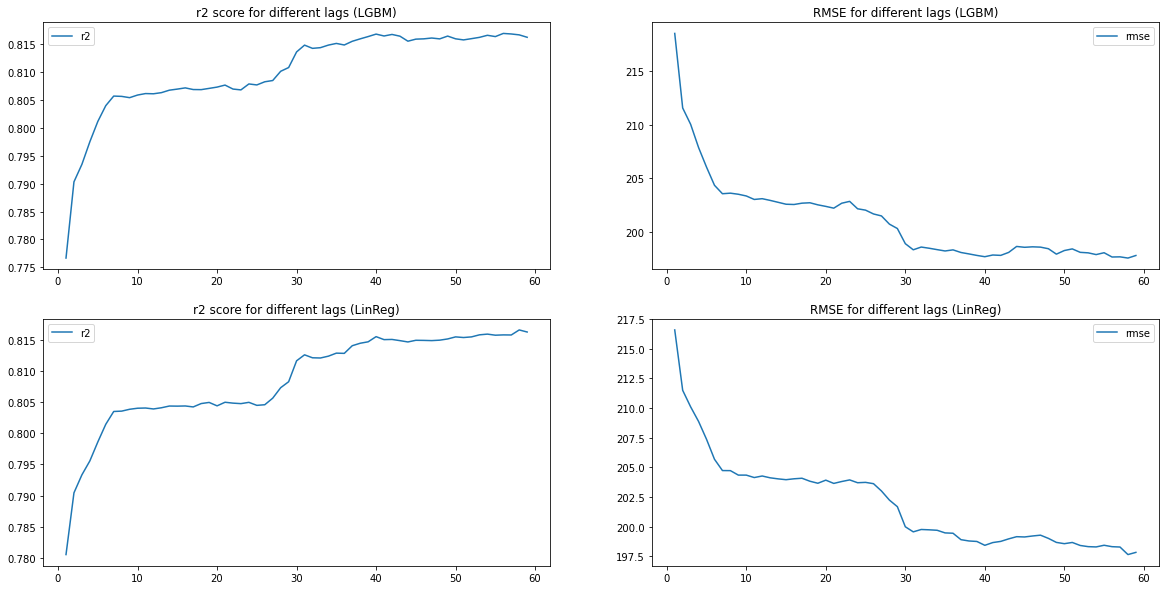

In [205]:
# проверим в рамках 'Mid' категории ресторана
evaluate_lags(df[df.restaurant_cat==1], ['consumption', 'sale_stop', 'write_off_p'], 60)

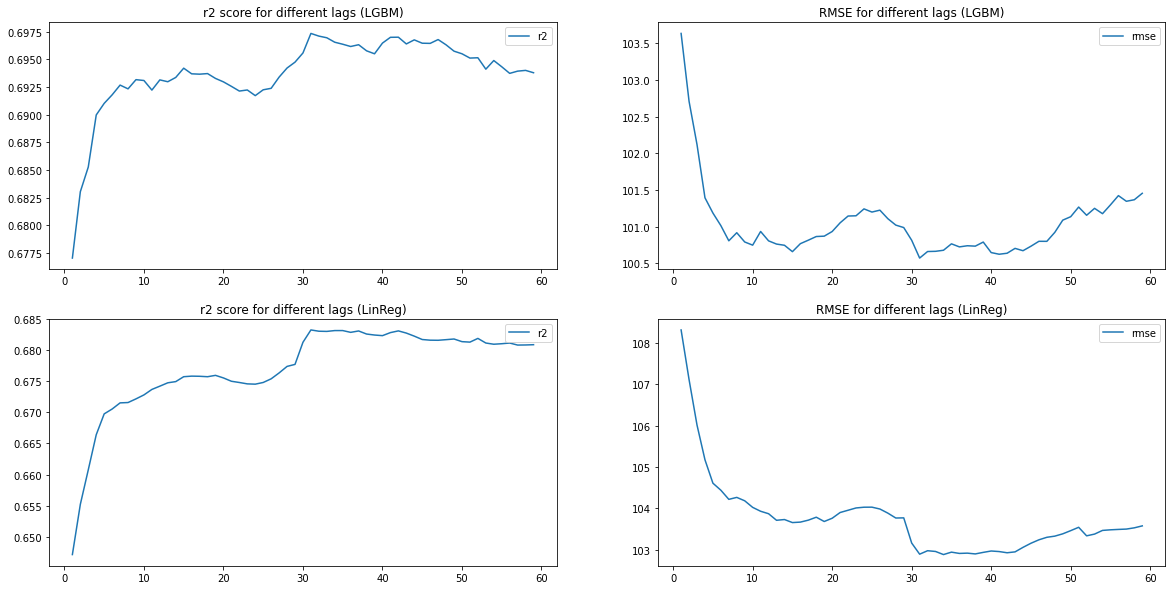

In [206]:
# проверим в рамках 'Low' категории ресторана 
evaluate_lags(df[df.restaurant_cat==0], ['consumption', 'sale_stop', 'write_off_p'], 60)

**Inference**: если исследовать оптимальные периоды на общем датасете, без разделения на категории ресторанов, кажется, что оптимальный период примерно месяц. Если посмотреть на те же периоды в разрезе трех категорий ресторанов картина немного меняется, заметно, что категория Hi на периоде после 30 дней начинает работать хуже, а у категории Mid на этом значении метрики стабилизируются. Также у категории Hi после 10 дней и более существенного улучшения метрик не происходит. У категории Low на выбранном диапазоне еще менее монотонные графики, из которых сложно сделать вывод об оптимальном периоде для этой категории. 

**Из этой оценки можно сделать вывод, что для разных категорий ресторанов могут быть разные оптимальные периоды. Похоже, что чем выше обороты ресторана, тем меньше исторических данных ему требуется для прогнозирования.
Также можно сделать вывод, что не во всех категориях обе модели одинаково реагируют на изменение периода.
Поэтому в рамках этой работы будет произведено сравнение различных моделей для отдельных категорий ресторанов.**

# Experiments

Соберем датасеты отдельно для каждой категории ресторана и опробуем на них разные модели.

In [285]:
# отдельные датасеты для категорий
def get_df_by_cat(category):
    data_res = []
    for filename in os.listdir(DATA_DIR + category):
        if 'data' in filename:
            arr_name = filename.split('_')
            df_temp = pd.read_csv(f'{DATA_DIR}{category}/{filename}', sep=';', parse_dates=['date'])
            df_temp['restaurant_id'] = arr_name[0]
            
            package_df = pd.read_csv(f'{DATA_DIR}{category}/{arr_name[0]}_package.csv', sep=';')
            df_new = pd.merge(df_temp, package_df, how='left', on = 'item_id')
            df_new.rename(columns={"k": "package"}, inplace=True)

            data_res.append(df_new)

    df = pd.concat(data_res)
    
    df['item_id'] = df['item_id'].map(map_ingridients)
    df['write_off_p'] = df['write_off'] / df['stock'] * 100
    df.drop(columns=['write_off', 'stock'], inplace=True) 
    
    df.drop(columns=['consumption_12'], inplace=True)
    
    set_date_index(df)
    
    return df

In [312]:
# добавление лагов, различных признаков из даты и экзогенные признаки
def add_new_features(df, cols_to_lag=[], max_lag=15, with_external=False, weather_drop=[]):
    df = df.copy(deep=True)
    set_date_index(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
 
    df = add_lag(df, max_lag, cols_to_lag)
       
    # external data
    if with_external:
        df = add_weather(df, weather_drop)
        df = pd.merge(df, get_calendar_df(), how='left', on='date')

    return df

In [311]:
def prepare_train_test_split(df, max_lag, with_external=False,
                             features_lag=['consumption', 'sale_stop', 'write_off_p'],
                             weather_drop=[],
                             test_size=0.2):
    temp_df = add_new_features(df, features_lag, max_lag, with_external, weather_drop)
    temp_df.dropna(inplace=True)
    set_date_index(temp_df)

    X = temp_df.drop(['consumption'], axis=1)
    y = temp_df['consumption']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [289]:
df_hi = get_df_by_cat('Hi')
df_mid = get_df_by_cat('Mid')
df_low = get_df_by_cat('Low')

In [290]:
def print_scores(scores, model=''):
    print(f'Metrics for {model}: ')
    for key, val in scores.items():
        print(f'{key}: {val}') 
    
def plot_r2_score(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=.25, color='C6')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
    plt.show();

    
def plot_model_forecasts(y_test, models_pred, x_num=100):
    plt.figure(figsize=(20, 5))
    plt.plot(y_test[:x_num].values, label="Real values")
    colors = {
        'LinReg': 'C1',
        'RF': 'C3',
        'LGBM': 'C4',
        'CatBoost': 'C6'
    }
    
    for key, val in models_pred.items():
        plt.plot(val[:x_num], label=key, color=colors[key], alpha=0.75)
    
    plt.legend(loc="best")
    plt.grid(True);

In [291]:
def eval_linreg(X_train, X_test, y_train, y_test):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    scores = get_scores(y_test, y_pred)
    print_scores(scores, model='Linear Regression')
    plot_r2_score(y_test, y_pred)
    
    return y_pred
    
def eval_RF(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_split=5, n_estimators=500)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    scores = get_scores(y_test, y_pred)
    print_scores(scores, model='Random Forest')
    plot_r2_score(y_test, y_pred)
    
    return y_pred

def eval_LGBM(X_train, X_test, y_train, y_test):
    lgb_model = lgb.LGBMRegressor(max_depth=8, learning_rate=0.1, n_estimators=500, num_leaves=16)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    
    scores = get_scores(y_test, y_pred)
    print_scores(scores, model='LightGBM')
    plot_r2_score(y_test, y_pred)
    
    return y_pred
    
def eval_catboost(X_train, X_test, y_train, y_test):
    catboost = CatBoostRegressor(depth=8, learning_rate=0.1, iterations=500, loss_function='RMSE', verbose=0)
    catboost.fit(X_train, y_train)
    y_pred = catboost.predict(X_test)

    scores = get_scores(y_test, y_pred)
    print_scores(scores, model='CatBoost')
    plot_r2_score(y_test, y_pred)
    
    return y_pred

In [292]:
# сравниваем разные модели
def evaluate_models(df, max_lag, with_external, plot_x=100):
    X_train, X_test, y_train, y_test = prepare_train_test_split(df, max_lag, with_external)

    preprocessor = get_preprocessor(X_train)

    X_train_t = preprocessor.fit_transform(X_train)
    X_test_t = preprocessor.transform(X_test)
    
    models_pred = {
        'LinReg': eval_linreg(X_train_t, X_test_t, y_train, y_test),
        'RF': eval_RF(X_train_t, X_test_t, y_train, y_test),
        'LGBM': eval_LGBM(X_train_t, X_test_t, y_train, y_test),
        'CatBoost': eval_catboost(X_train, X_test, y_train, y_test)
    }
    
    plot_model_forecasts(y_test, models_pred, plot_x)

Metrics for Linear Regression: 
r2: 0.8292801542913133
rmse: 364.41603429248755
wape: 28.347145378733217
mae: 204.24580204827666
med_mae: 90.363


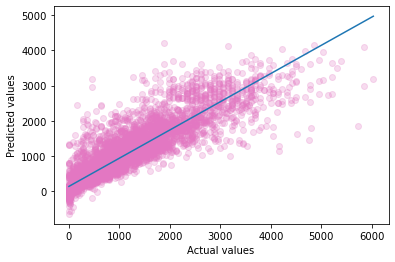

Metrics for Random Forest: 
r2: 0.826762456045391
rmse: 367.0933201192512
wape: 26.513622509281387
mae: 191.03497097369487
med_mae: 65.7526233314633


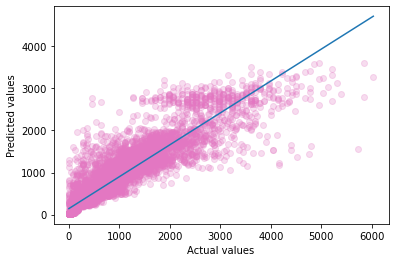

Metrics for LightGBM: 
r2: 0.861778601444065
rmse: 327.90128177915955
wape: 24.33640974829994
mae: 175.3477982211964
med_mae: 61.45859376064067


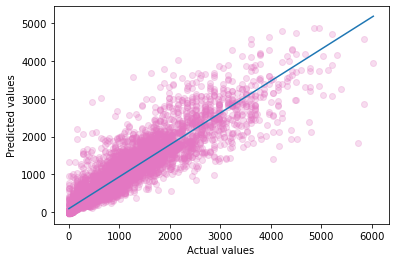

Metrics for CatBoost: 
r2: 0.8621177845253687
rmse: 327.4987142959244
wape: 24.252919635121593
mae: 174.74623834977413
med_mae: 63.58261577059511


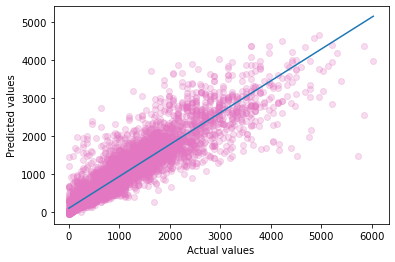

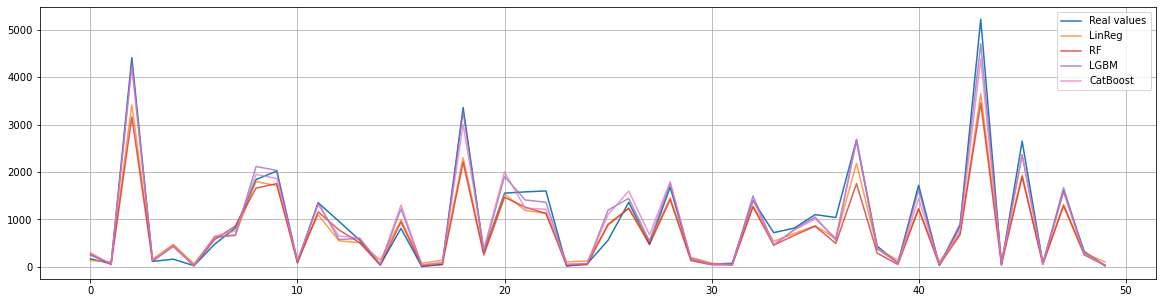

In [293]:
evaluate_models(df_hi, 10, False, 50)

Metrics for Linear Regression: 
r2: 0.8045423404580898
rmse: 203.89733475828723
wape: 31.239083676688722
mae: 117.29836099416853
med_mae: 51.241943359375


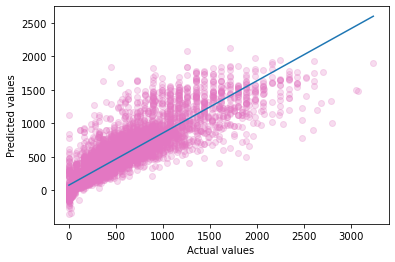

Metrics for Random Forest: 
r2: 0.7958722610947524
rmse: 208.37049065344166
wape: 29.95752469497159
mae: 112.48628745102059
med_mae: 42.406048948584065


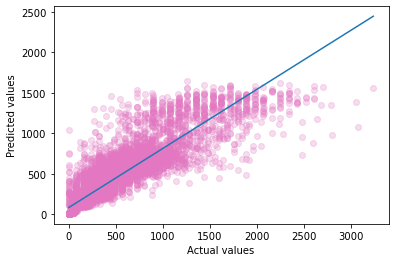

Metrics for LightGBM: 
r2: 0.828021436737208
rmse: 191.2592111141977
wape: 27.71152514597135
mae: 104.0528753632013
med_mae: 37.64518241288698


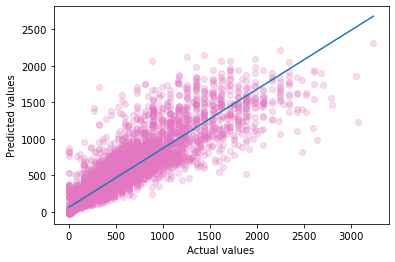

Metrics for CatBoost: 
r2: 0.8295302464348131
rmse: 190.4183810983787
wape: 27.689497555463788
mae: 103.97016486215327
med_mae: 37.47387479836857


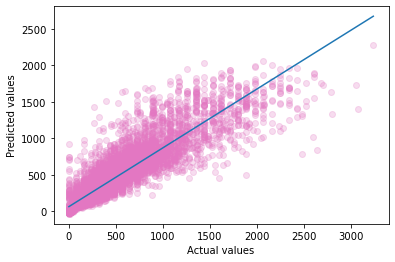

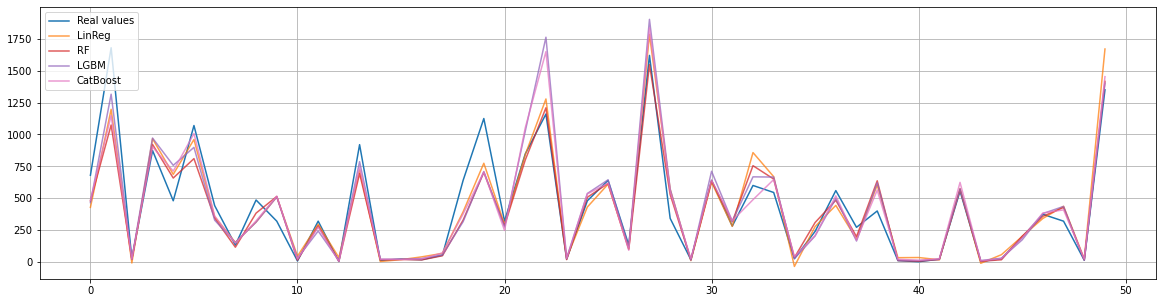

In [294]:
evaluate_models(df_mid, 10, False, 50)

Metrics for Linear Regression: 
r2: 0.6808406449944309
rmse: 103.21915977695369
wape: 45.403566195683354
mae: 60.10603692833398
med_mae: 27.6142578125


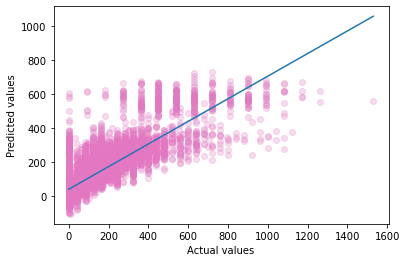

Metrics for Random Forest: 
r2: 0.6773833064716859
rmse: 103.77672189677577
wape: 43.304167510281935
mae: 57.32681614272001
med_mae: 22.924258628352867


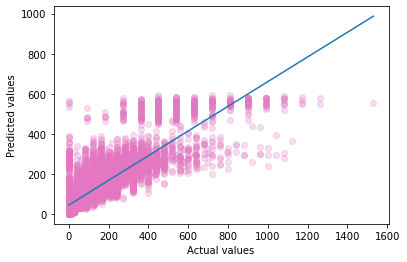

Metrics for LightGBM: 
r2: 0.7118165600583892
rmse: 98.08239018237792
wape: 39.5303534125521
mae: 52.33097487903562
med_mae: 16.73188805484389


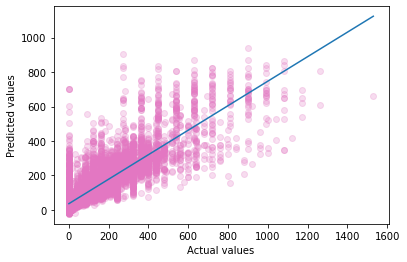

Metrics for CatBoost: 
r2: 0.7156022277627055
rmse: 97.43604004019065
wape: 39.814884963532236
mae: 52.70764273452497
med_mae: 17.76842442986259


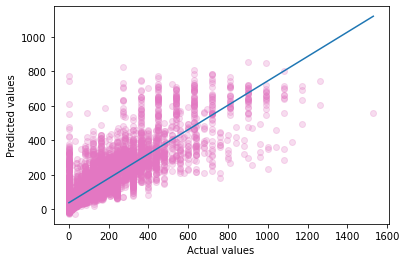

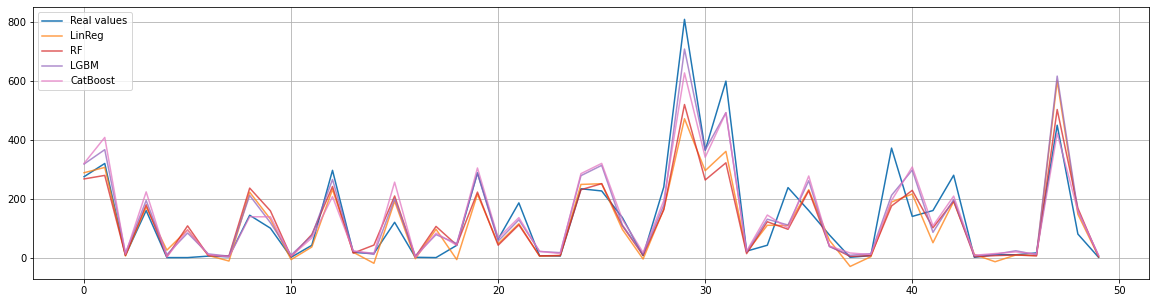

In [295]:
evaluate_models(df_low, 30, False, 50)

### Добавление новых фич и внешних признаков

In [296]:
# добавляем архив погоды за 2020-2021 гг.
def add_weather(df, feat_to_drop=[]):
    weather_df = pd.read_json(DATA_DIR + 'weather.json')
    weather_df.drop_duplicates(inplace=True)
    df = pd.merge(df, weather_df, how='left', on = 'date')
    df.drop(columns=feat_to_drop, axis=1, inplace=True)
    
    return df

In [297]:
# получить производственный календарь России за 2020-2021 гг. 
dates = []
start_date = datetime.date(year=2020, month=1, day=1)
end_date = datetime.date(year=2021, month=12,  day=31)

current_date = start_date

while current_date <= end_date:
    dates.append(current_date)
    current_date += datetime.timedelta(days=1)

df_calendar = pd.DataFrame(dates, columns=['date'])
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

def get_calendar_df():
    if 'day_off' in df_calendar.columns:
        return df_calendar

    # 0 Рабочий день 1 Нерабочий день 2 Сокращённый рабочий день 4 Рабочий день (с учетом COVID)
    days = []

    for year in [2020, 2021]:
        query = {
            'cc':'ru',
            'year': year,
            'pre': 1,
            'delimeter': ';',
            'covid': 1,
            'sd': 0
        }

        response = requests.get('https://isdayoff.ru/api/getdata', params=query)

        days.extend([int(i) for i in response.text.split(';')])

    df_calendar['day_off'] = days
    
    return df_calendar

Metrics for Linear Regression: 
r2: 0.8295110766285188
rmse: 364.0797144233952
wape: 28.657814696721633
mae: 206.38557784394223
med_mae: 96.31640625


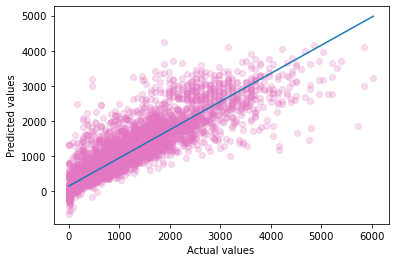

Metrics for Random Forest: 
r2: 0.828800138818565
rmse: 364.83802983939376
wape: 26.418461902132158
mae: 190.2583844274578
med_mae: 65.04484262314448


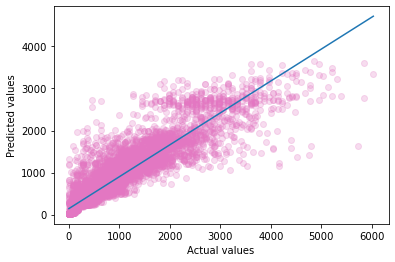

Metrics for LightGBM: 
r2: 0.8680457747186612
rmse: 320.3022934605764
wape: 24.101467866629235
mae: 173.5720404776895
med_mae: 64.98889227843262


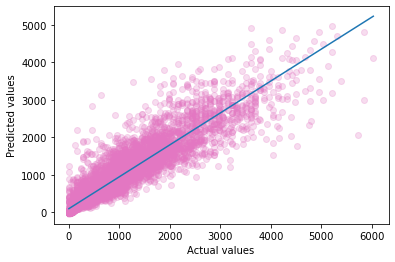

Metrics for CatBoost: 
r2: 0.8622762207528996
rmse: 327.2298125128348
wape: 24.614836160105632
mae: 177.26917555296131
med_mae: 65.81849276843002


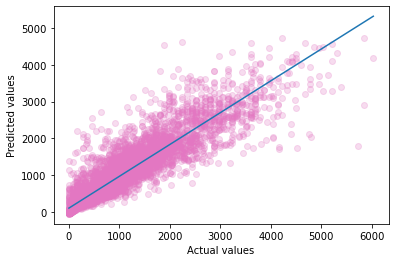

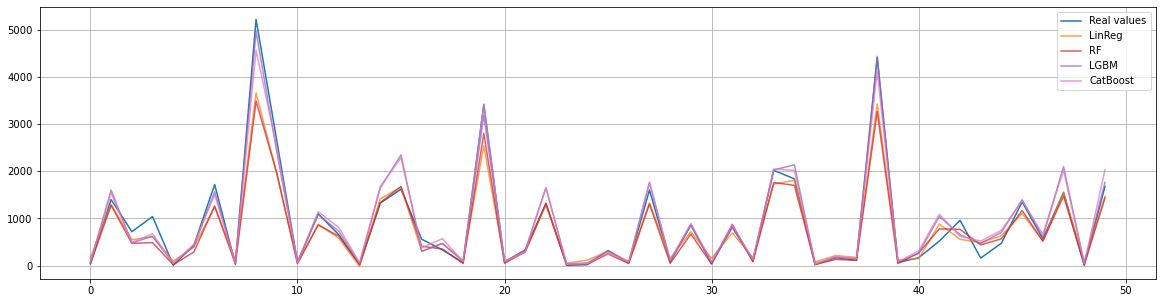

In [313]:
df_hi_external = add_new_features(df_hi, ['consumption', 'sale_stop', 'write_off_p'], 10, True)

evaluate_models(df_hi_external, 10, True, 50)

Metrics for Linear Regression: 
r2: 0.8045888731439128
rmse: 203.95006020215098
wape: 31.26289790747933
mae: 117.17301570204636
med_mae: 50.40625


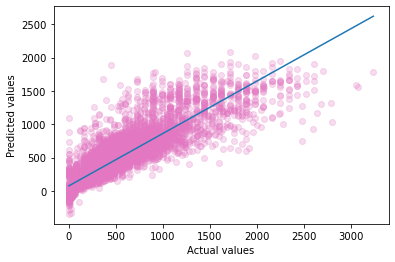

Metrics for Random Forest: 
r2: 0.7939091050762667
rmse: 209.44914692130467
wape: 30.14476989475059
mae: 112.98228355750567
med_mae: 41.845107688914595


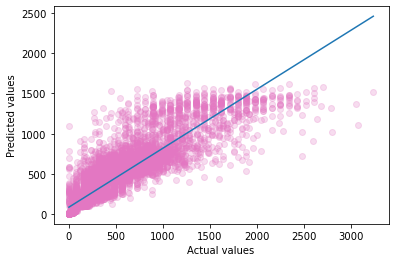

Metrics for LightGBM: 
r2: 0.8174977642103632
rmse: 197.09848582857532
wape: 28.428936738448613
mae: 106.55135876094768
med_mae: 38.50048912762169


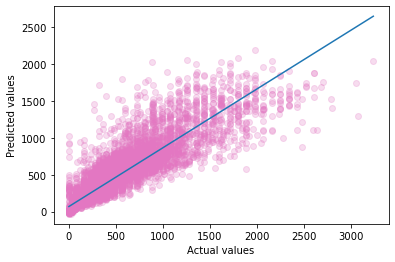

Metrics for CatBoost: 
r2: 0.8247591858260768
rmse: 193.1375973356986
wape: 28.064483494822813
mae: 105.18539180022618
med_mae: 38.20484680316582


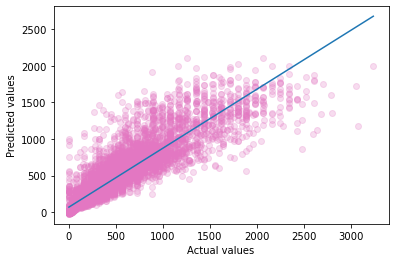

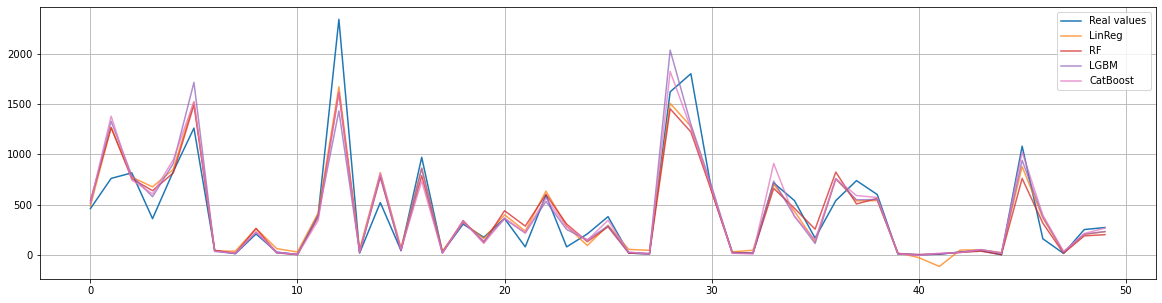

In [411]:
df_mid_external = add_new_features(df_mid, ['consumption', 'sale_stop', 'write_off_p'], 10, True)

evaluate_models(df_mid_external, 20, True, 50)

Metrics for Linear Regression: 
r2: 0.6809310091378539
rmse: 103.29147447589686
wape: 45.66438508230124
mae: 60.503448876839656
med_mae: 27.767578125


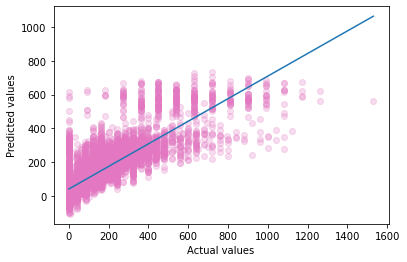

Metrics for Random Forest: 
r2: 0.678517068813431
rmse: 103.68146792406215
wape: 43.28786490885783
mae: 57.35465651798992
med_mae: 23.05694853670107


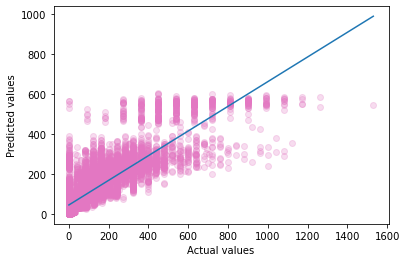

Metrics for LightGBM: 
r2: 0.7145648327813882
rmse: 97.69580536570048
wape: 39.69304753443512
mae: 52.59167002768779
med_mae: 17.552463561318767


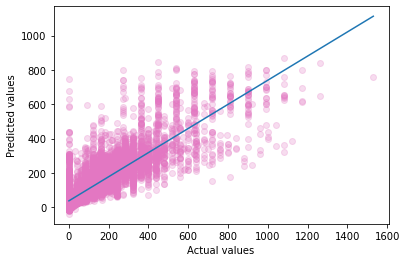

Metrics for CatBoost: 
r2: 0.7172497338523365
rmse: 97.23523962221232
wape: 39.80986056495399
mae: 52.7464425316297
med_mae: 18.261990155728455


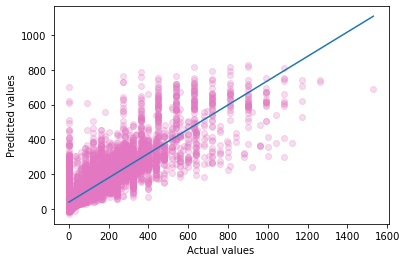

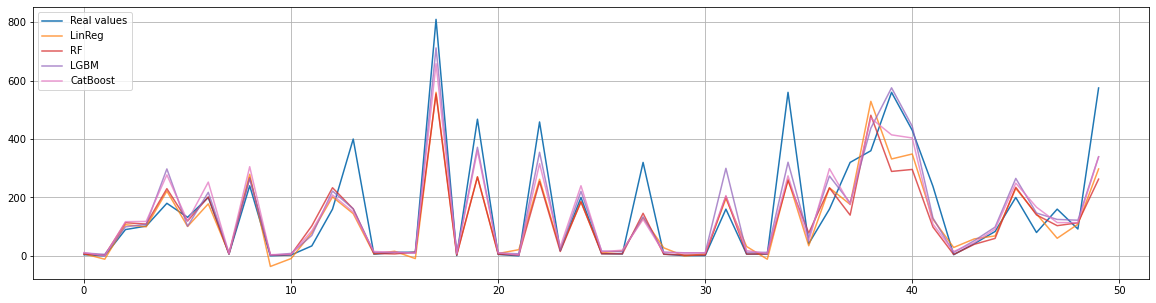

In [407]:
df_low_external = add_new_features(df_low, ['consumption', 'sale_stop', 'write_off_p'], 30, True)

evaluate_models(df_low_external, 30, True, 50)

### Добавление сезонной декомпозиции, скользящей средней

In [375]:
set_date_index(df_hi_external)
df_hi_season = df_hi_external.copy(deep=True)

df_hi_season['rolling_mean'] = df_hi_season.groupby(['restaurant_id','item_id'])['lag(consumption,1)'].transform(lambda x: x.rolling(7, 1).mean())

decomposed_data = seasonal_decompose(df_hi_season.groupby(df_hi_season.index).agg({'lag(consumption,1)': 'mean'}))

df_hi_season = df_hi_season.join(decomposed_data.trend)
df_hi_season = df_hi_season.join(decomposed_data.seasonal)
df_hi_season = df_hi_season.join(decomposed_data.resid)

df_hi_season.dropna(inplace=True)

Metrics for Linear Regression: 
r2: 0.8358290844942755
rmse: 354.96285456874153
wape: 28.983895194753828
mae: 208.15453483893558
med_mae: 108.1875


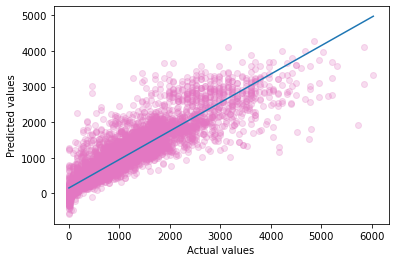

Metrics for Random Forest: 
r2: 0.8415485093528157
rmse: 348.7249035639431
wape: 25.562151196663645
mae: 183.58049034027513
med_mae: 66.97288963093973


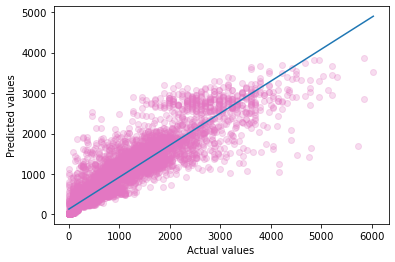

Metrics for LightGBM: 
r2: 0.8728386449937582
rmse: 312.40096860934403
wape: 23.46351431757247
mae: 168.5086450818053
med_mae: 61.080255981467815


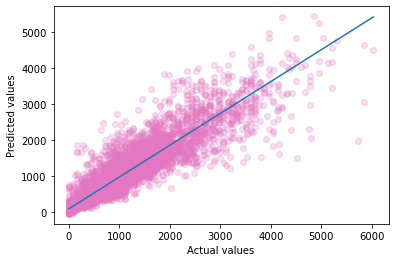

Metrics for CatBoost: 
r2: 0.8722800458609503
rmse: 313.086380009739
wape: 23.613321064723323
mae: 169.5845168222799
med_mae: 61.12079965080375


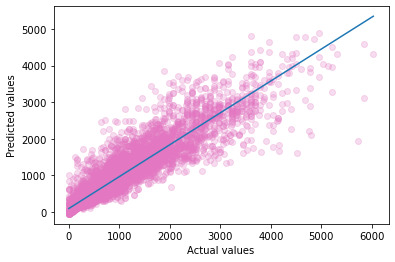

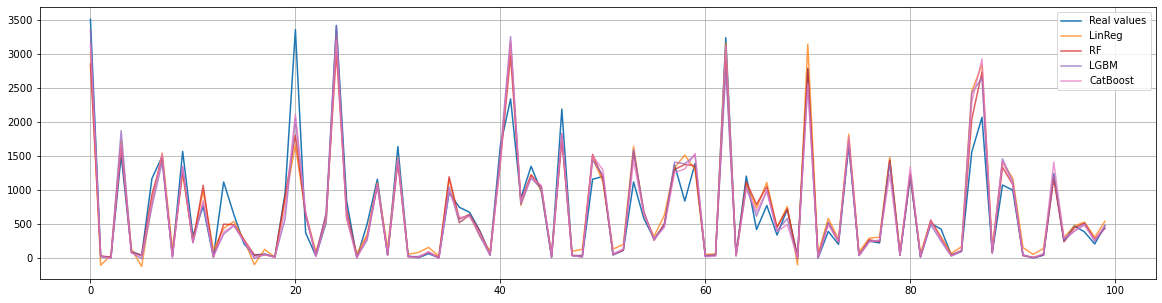

In [408]:
evaluate_models(df_hi_season, 10, False, 100)

In [385]:
set_date_index(df_mid_external)
df_mid_season = df_mid_external.copy(deep=True)

df_mid_season['rolling_mean'] = df_mid_season.groupby(['restaurant_id','item_id'])['lag(consumption,1)'].transform(lambda x: x.rolling(7, 1).mean())
df_mid_season.fillna(method='bfill', inplace=True)
decomposed_data = seasonal_decompose(df_mid_season.groupby(df_mid_season.index).agg({'lag(consumption,1)': 'mean'}))

df_mid_season = df_mid_season.join(decomposed_data.trend)
df_mid_season = df_mid_season.join(decomposed_data.seasonal)
df_mid_season = df_mid_season.join(decomposed_data.resid)

df_mid_season.dropna(inplace=True)

Metrics for Linear Regression: 
r2: 0.8097255594068208
rmse: 201.4893469819926
wape: 31.697964606069785
mae: 119.54448981156295
med_mae: 58.41748046875


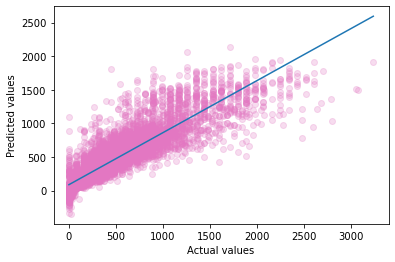

Metrics for Random Forest: 
r2: 0.8059067520870143
rmse: 203.5012476452824
wape: 29.268796762525756
mae: 110.38321923371906
med_mae: 41.783119572094904


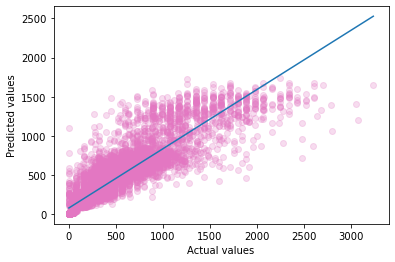

Metrics for LightGBM: 
r2: 0.8385748795873362
rmse: 185.58694465107652
wape: 26.803488675835773
mae: 101.08565072689943
med_mae: 37.4510408314852


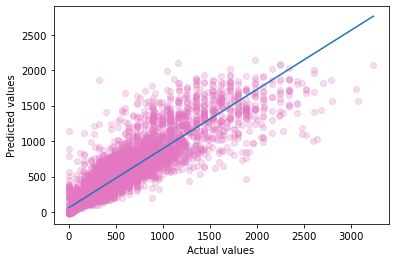

Metrics for CatBoost: 
r2: 0.8399813701964634
rmse: 184.77667000905475
wape: 27.049340699780295
mae: 102.01284763486613
med_mae: 38.42519235570066


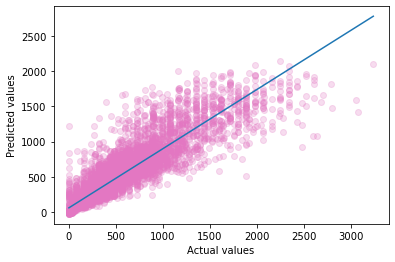

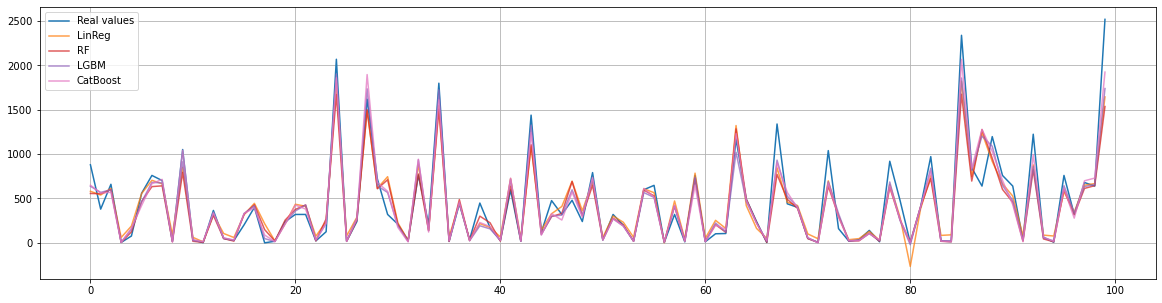

In [409]:
evaluate_models(df_mid_season, 10, False, 100)

In [405]:
set_date_index(df_low_external)
df_low_season = df_low_external.copy(deep=True)

df_low_season['rolling_mean'] = df_low_season.groupby(['restaurant_id','item_id'])['lag(consumption,1)'].transform(lambda x: x.rolling(7, 1).mean())
df_low_season.dropna(inplace=True)

decomposed_data = seasonal_decompose(df_low_season.groupby(df_low_season.index).agg({'lag(consumption,1)': 'mean'}))

df_low_season = df_low_season.join(decomposed_data.trend)
df_low_season = df_low_season.join(decomposed_data.seasonal)
df_low_season = df_low_season.join(decomposed_data.resid)

df_low_season.dropna(inplace=True)

Metrics for Linear Regression: 
r2: 0.681616177218573
rmse: 103.22510688491982
wape: 46.87652450963724
mae: 62.0083504305022
med_mae: 30.51953125


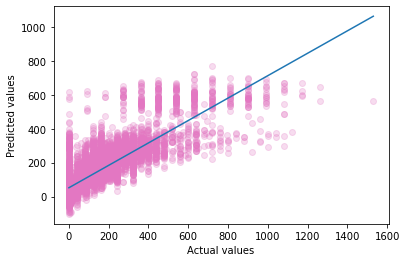

Metrics for Random Forest: 
r2: 0.6824416401457971
rmse: 103.09120592356655
wape: 42.81929358706397
mae: 56.64143811231884
med_mae: 23.075411270427466


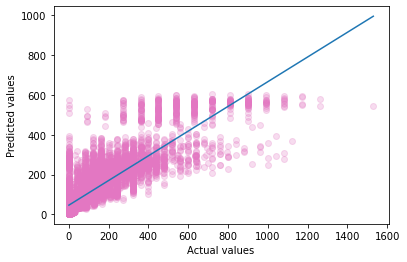

Metrics for LightGBM: 
r2: 0.7206044785596373
rmse: 96.69846162133143
wape: 39.298484306083495
mae: 51.984105300686764
med_mae: 17.55591963766301


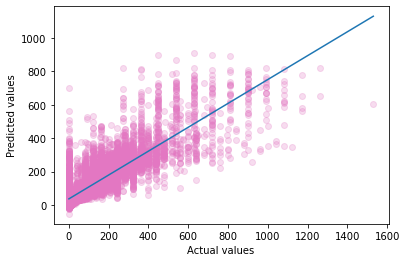

Metrics for CatBoost: 
r2: 0.72171143801981
rmse: 96.50671282248527
wape: 39.282813676720515
mae: 51.963376164148364
med_mae: 17.79479224112758


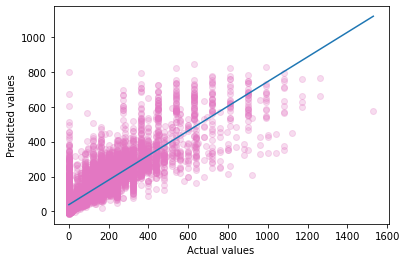

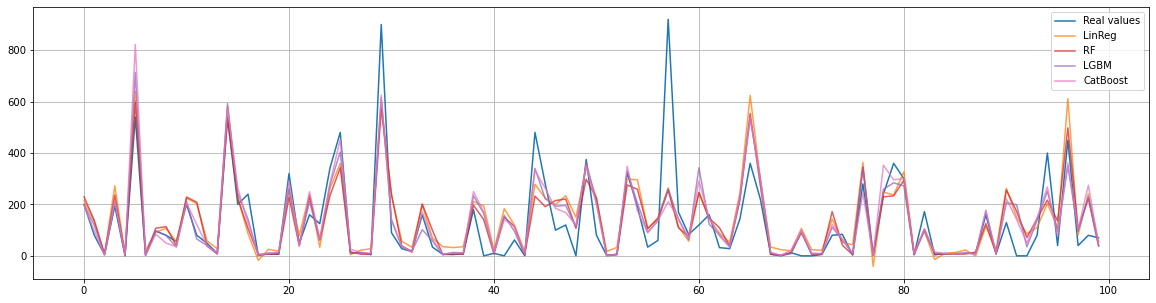

In [410]:
evaluate_models(df_low_season, 30, False, 100)

Metrics for Linear Regression: 
r2: 0.8392306769467679
rmse: 250.8489382580693
wape: 33.14734814866099
mae: 134.63403838066733
med_mae: 64.30859375


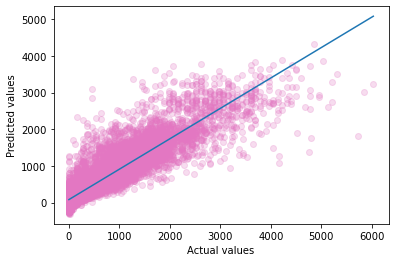

Metrics for Random Forest: 
r2: 0.8416909279135765
rmse: 248.92216940601176
wape: 29.562345408831938
mae: 120.07289176030335
med_mae: 38.90393087683245


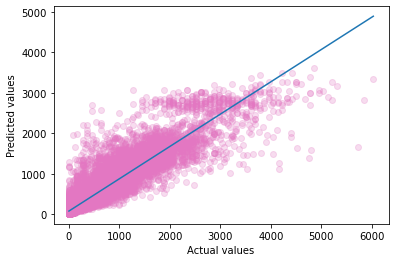

Metrics for LightGBM: 
r2: 0.8816560686634205
rmse: 215.2205177144341
wape: 26.402017029734353
mae: 107.23663800091646
med_mae: 33.99932050776902


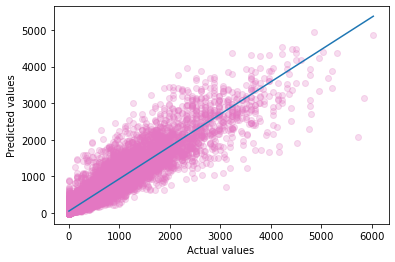

Metrics for CatBoost: 
r2: 0.8797531091653419
rmse: 216.94398010006068
wape: 26.673672061241543
mae: 108.34001477103276
med_mae: 35.39637066662874


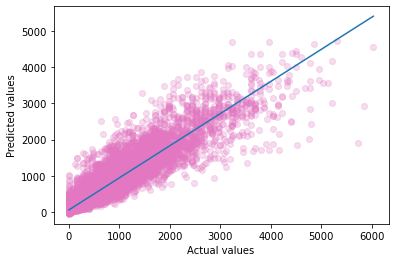

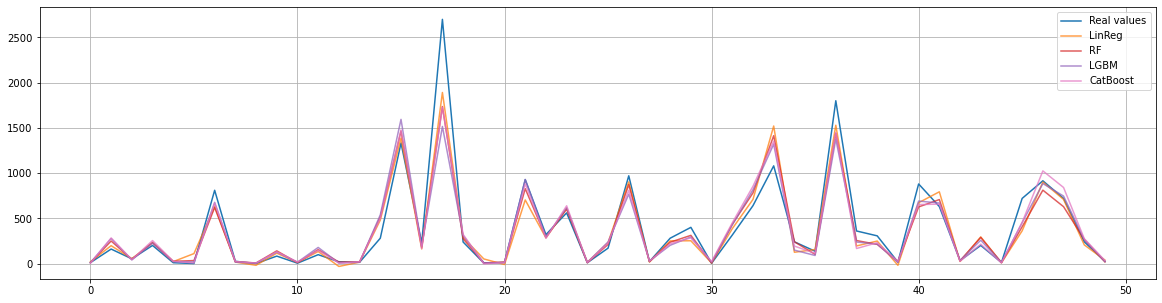

In [412]:
df_all_external = add_new_features(df, ['consumption', 'sale_stop', 'write_off_p'], 20, True)

set_date_index(df_all_external)
df_all_season = df_all_external.copy(deep=True)

df_all_season['rolling_mean'] = df_all_season.groupby(['restaurant_id','item_id'])['lag(consumption,1)'].transform(lambda x: x.rolling(7, 1).mean())
df_all_season.dropna(inplace=True)

decomposed_data = seasonal_decompose(df_all_season.groupby(df_all_season.index).agg({'lag(consumption,1)': 'mean'}))

df_all_season = df_all_season.join(decomposed_data.trend)
df_all_season = df_all_season.join(decomposed_data.seasonal)
df_all_season = df_all_season.join(decomposed_data.resid)

df_all_season.dropna(inplace=True)

evaluate_models(df_all_season, 20, False, 50)

- в категориях Hi, Mid, Low были взяты лаги за 10, 20, 30 дней соответственно (для  признаков 'consumption', 'sale_stop', 'write_off_p'
- добавлены новые временные признаки 'year', 'month', 'day', 'dayofweek' - незначительное улучшение метрик
- добавлены экзогенные признаки (производственный календарь РФ с учетом выходных и рабочих дней во время локдауна из-за COVID), а также архив погоды -- признаки avgtempC, uvIndex, sunHour, totalSnow_cm - незначительное улучшение метрик
- опробованы модели LinearRegression, RandomForestRegressor, LGBMRegressor и CatBoostRegressor. Наилучшие метрики продемонстрировал CatBoostRegressor, самые слабые результаты у LinearRegression, самый медленный фит - RandomForestRegressor.
- после сравнения моделей для каждой категории отдельно такие же действия были произведены с общим датасетом (отличие в признаке restaurant_cat), все модели на едином датасете сработали лучше (на периоде 20 дней).

**Выводы:** модели показывают сравнительно низкую точность у ресторанов категории Low, все категории вместе предсказываются лучше всеми моделями. Без разделения на категории 

### Parameters Tuning

Ищем лучшие гиперпараметры для моделей LGBMRegressor и CatBoostRegressor, поскольку они показывают стабильно лучшее качество (в сравнении с линейной регрессией) и гораздо быстрее фитятся (по сравнению с RF).

In [413]:
# TSS для кросс-валидации временных рядов 
tss = TimeSeriesSplit(max_train_size=None, n_splits=6)

In [415]:
X_train, X_test, y_train, y_test = prepare_train_test_split(df_all_season, 20, False)

preprocessor = get_preprocessor(X_train)

X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

#### LGBMRegressor

In [ ]:
%%time

train_data = lgb.Dataset(X_train_t, y_train)
test_data = lgb.Dataset(X_test, y_test, reference = train_data)

params = {
    'num_leaves': [16, 32, 42, 55],
    'learning_rate': [0.1, 0.25, 0.3, 0.4, 0.5],
    'max_depth': [8, 32, 64],
    'n_estimators': [500, 750, 1000, 1500]
}

grid = GridSearchCV(lgb.LGBMRegressor(), params, cv=tss, scoring='r2', verbose=0)

grid.fit(X_train_t, y_train)

lgbm_best = grid.best_params_

print(f'Best parameters: {lgbm_best}')
print(f'Best score: {grid.best_score_}')

In [430]:
# Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'num_leaves': 16}

In [ ]:
gbm = lgb.train(lgbm_best, train_data, num_boost_round=50)
y_pred_lgbm = gbm.predict(X_test_t, num_iteration=gbm.best_iteration)

Metrics for : 
r2: 0.8816560686634205
rmse: 215.2205177144341
wape: 26.402017029734353
mae: 107.23663800091646
med_mae: 33.99932050776902


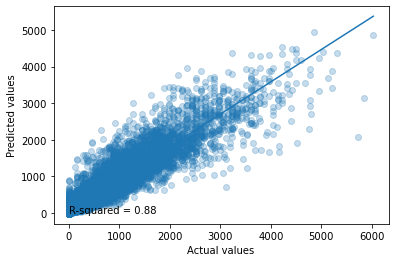

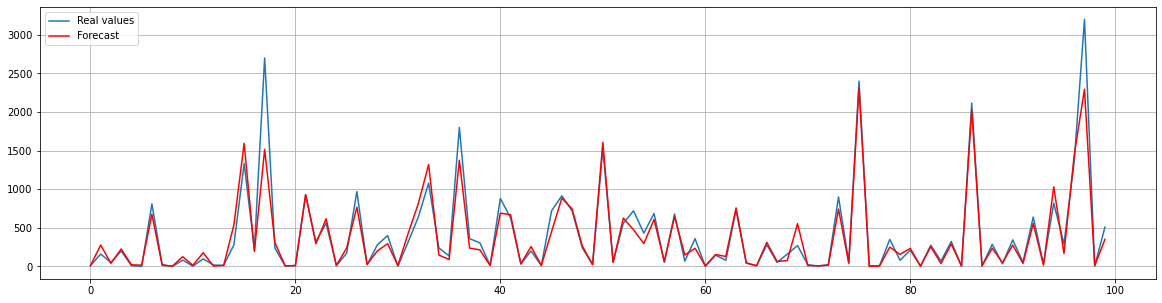

In [432]:
scores = get_scores(y_test, y_pred_lgbm)
print_scores(scores)
plot_forecast(y_test, y_pred_lgbm)

#### CatBoostRegressor

In [ ]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')

parameters_cat = {
    'depth': [8, 32, 64],
    'learning_rate': [0.01, 0.1, 0.25, 0.3, 0.4, 0.5],
    'n_estimators': [500, 750, 1000, 1500]
}

catboost_grid = catboost.grid_search(parameters_cat, Pool(X_train, y_train),
                                     cv=tss, shuffle=False, verbose=0)

In [434]:
print(catboost_grid['params'])
# {'depth':8, 'iterations': 1500, 'learning_rate': 0.1}

{'depth': 8, 'iterations': 1500, 'learning_rate': 0.1}


In [439]:
final_cat = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid['params']['learning_rate'],
                              iterations=catboost_grid['params']['iterations'],
                              loss_function='RMSE',verbose=1000)

final_cat.fit(Pool(X_train, y_train))

0:	learn: 550.4821923	total: 36.1ms	remaining: 54.1s
1000:	learn: 102.3396594	total: 24.5s	remaining: 12.2s
1499:	learn: 82.2067989	total: 36.5s	remaining: 0us


Metrics for : 
r2: 0.8800612006523758
rmse: 216.66587951610742
wape: 26.502571926710182
mae: 107.64506017086158
med_mae: 34.079193060316456


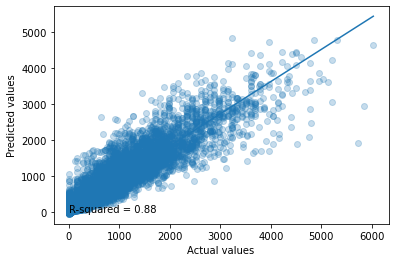

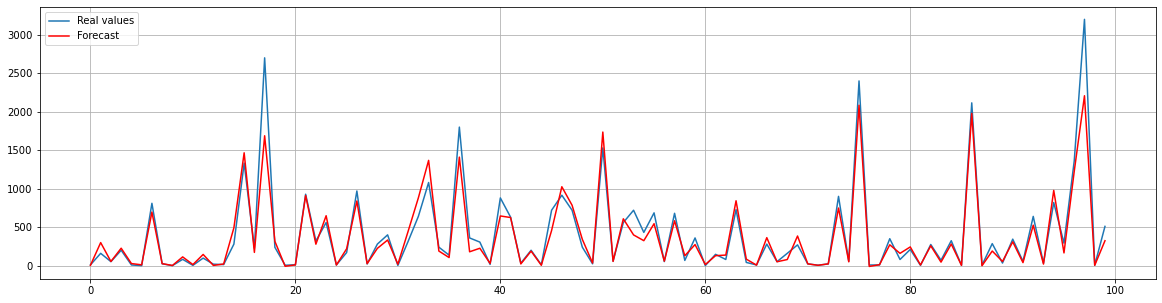

In [440]:
y_pred_cb = final_cat.predict(X_test)

scores = get_scores(y_test, y_pred_cb)
print_scores(scores)
plot_forecast(y_test, y_pred_cb)

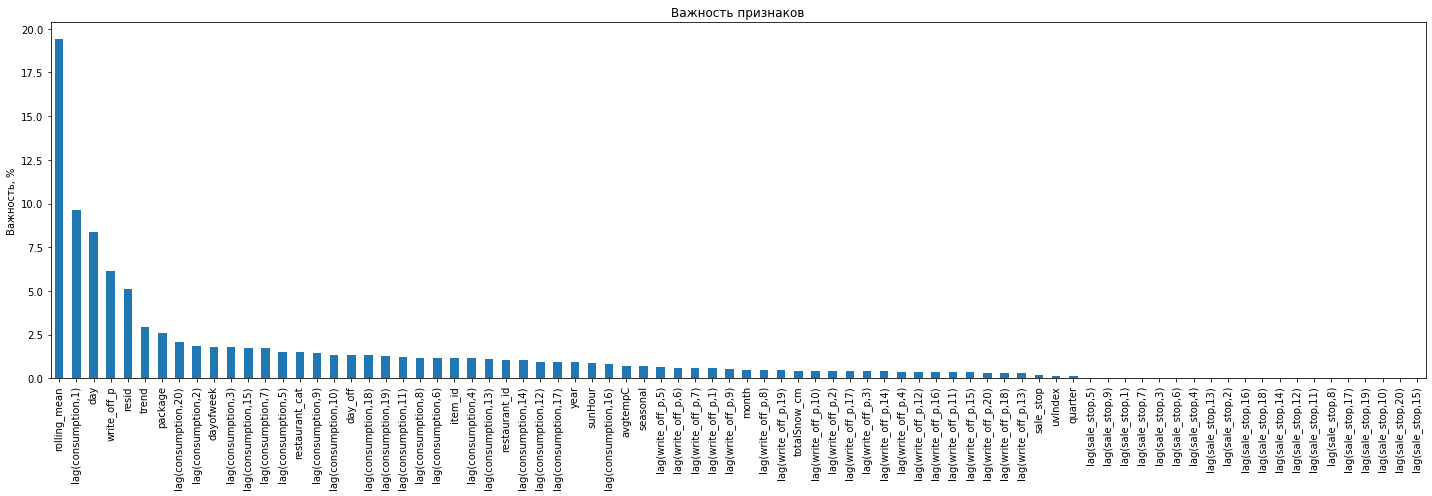

In [448]:
# посмотрим на важность признаков
cat_iris_imp = pd.Series(final_cat.get_feature_importance(), X_train.columns)
fig, ax = plt.subplots(figsize=(20,7))
cat_iris_imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance, %')
fig.tight_layout()

In [ ]:
# убираем неважные фичи

In [513]:
df_copy = df.copy(deep=True)

In [514]:
df_copy = add_new_features(df_copy, ['consumption', 'write_off_p'], 20, False)

df_copy['rolling_mean'] = df_copy.groupby(['restaurant_id','item_id'])['lag(consumption,1)'].transform(lambda x: x.rolling(7, 1).mean())
df_copy.dropna(inplace=True)

decomposed_data = seasonal_decompose(df_copy.groupby(df_copy.index).agg({'lag(consumption,1)': 'mean'}))

df_copy = df_copy.join(decomposed_data.trend)
df_copy = df_copy.join(decomposed_data.seasonal)
df_copy = df_copy.join(decomposed_data.resid)

df_copy.dropna(inplace=True)


In [515]:
X_train_, X_test_, y_train_, y_test_ = prepare_train_test_split(
    df_copy, 7, True, ['consumption', 'write_off_p'], ['uvIndex'])

In [516]:
cb_ = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid['params']['learning_rate'],
                              iterations=catboost_grid['params']['iterations'],
                              loss_function='RMSE',verbose=1000)

cb_.fit(Pool(X_train_, y_train_))

0:	learn: 549.2392169	total: 32.1ms	remaining: 48s
1000:	learn: 102.6968983	total: 22.4s	remaining: 11.2s
1499:	learn: 82.4852184	total: 35.1s	remaining: 0us


Metrics for : 
r2: 0.8805448228257308
rmse: 216.54862982783632
wape: 26.41308678844577
mae: 107.51997894622775
med_mae: 33.84175794460043


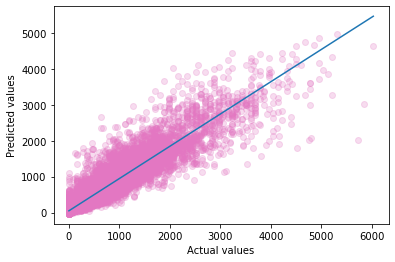

In [517]:
y_pred_cb_ = cb_.predict(X_test_)

scores_ = get_scores(y_test_, y_pred_cb_)
print_scores(scores_)
plot_r2_score(y_test_, y_pred_cb_)

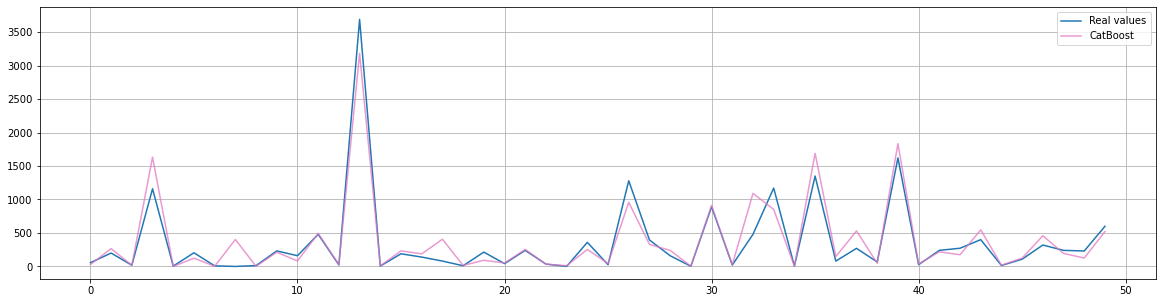

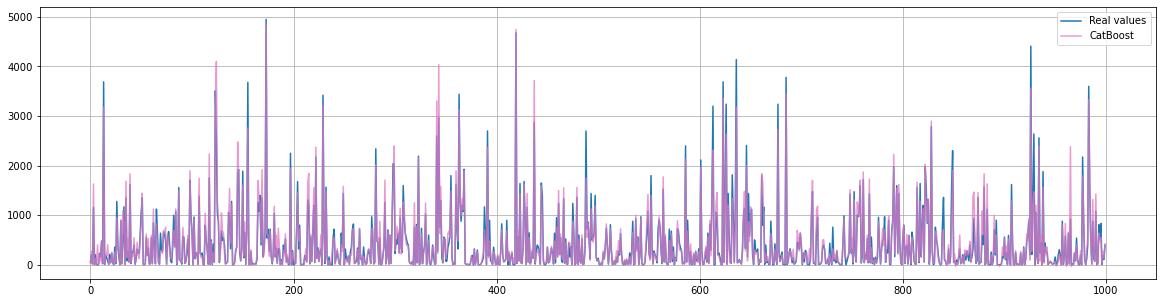

In [533]:
plot_model_forecasts(y_test_, {'CatBoost': y_pred_cb_}, 50)
plot_model_forecasts(y_test_, {'CatBoost': y_pred_cb_}, 1000)

**Inference**: удаление наименее важных признаков не дает существенного улучшения метрик, можно отметить только, что незначительно уменьшилась медианная абсолютная ошибка. Из графика r2 видно, что отдельные прогнозируемые значения сильно отклоняются от реальных значений. На графике с наложением прогноза на фактические значения видно, что модель иногда недопрогнозирует некоторые повышенные значения.

В целом можно сделать вывод, что отдельные модели с разделением на категории по отдельности справляются хуже, чем модель, обученная на общем датасете. Особенно это видно по метрикам модели для категории Low. Общая модель справляется лучше, целевая переменная объясняется лучше, а в сравнении с моделями по отдельным категориям метрики ошибок изменяются в меньшую сторону для категории Hi и в большую сторону для категорий Mid и Low.

Стоит отметить проведенные эксперименты с новыми признаками. Добавление новых признаков (день, день недели, месяц, квартал, год) и внешних признаков (погодные условия, праздничные дни), и также эксперименты с лагами сезонной декомпозиции дают некоторое улучшение показателей в основном для случайного леса и градиентного бустинга. Для линейной регрессии это действие, наоборот, приводит к увеличению метрик ошибок (в случае с медианной абсолютной ошибкой это наблюдается во всех моделях в разных категориях).

Анализ важности признаков показал, что остановки продаж в прошлом и УФ-индекс являются наименее важными признаками.

